In [2]:
import pandas as pd
import numpy as np
from decimal import Decimal as Dec
import matplotlib.pyplot as plt
import sympy

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
folder_path = "numerical_detail"
num_results_df = pd.DataFrame()

for csv in sorted(os.listdir(folder_path)):
    row_dict = {}
    if "epoc" in csv:
        df = pd.read_csv(folder_path + "/" + csv)
        # df = df.iloc[:-1]
        row_dict['pool'] = csv
        b = float(csv[:-9].replace("_", "."))
        row_dict['b'] = b
        row_dict['rebase_time'] = len(df) - 1
        row_dict['swap_time'] = df.iloc[-1]['epoc_end_index'] - 1
        row_dict['mean_stopping_time'] = row_dict['swap_time'] / row_dict['rebase_time']

        row_dict['pnl_mean'] = np.mean(df['end_wealth'] - df['holding_wealth'])
        row_dict['fee_wealth_mean'] = np.mean(df['end_wealth_fee'])
        row_dict['IL_mean'] = np.mean(df['end_wealth_in_pool'] - df['holding_wealth'])
        row_dict['theo_IL'] = -(np.exp(b) - np.exp(-b)) / 4 * 20
        row_dict['theo_pnl_mean'] = row_dict['theo_IL'] + row_dict['fee_wealth_mean']

        row_dict['pnl_apr'] = row_dict['pnl_mean'] / np.mean(df['invest_wealth'])
        row_dict['fee_wealth_apr'] = row_dict['fee_wealth_mean'] / np.mean(df['invest_wealth'])
        row_dict['IL_mean_apr'] = row_dict['IL_mean'] / np.mean(df['invest_wealth'])
        row_dict['theo_IL_apr'] = row_dict['theo_IL'] / np.mean(df['invest_wealth'])
        row_dict['theo_pnl_apr'] = row_dict['theo_pnl_mean'] / np.mean(df['invest_wealth'])
        row_dict['effective_tx_ratio'] = sum(df['epoc_effective_tx_count']) / row_dict['swap_time']

        num_results_df = num_results_df.append(row_dict, ignore_index=True)

demo_df = num_results_df[['pool', 'b', 'rebase_time', 'swap_time', 'mean_stopping_time', 'fee_wealth_mean',
                          'IL_mean', 'theo_IL', 'pnl_mean', 'theo_pnl_mean', 'fee_wealth_apr', 'IL_mean_apr', 
                          'theo_IL_apr', 'pnl_apr', 'theo_pnl_apr', 'effective_tx_ratio']]
demo_df
demo_df.to_csv("numerical_detail.csv")

0.9872044065815017 1.007147258474766


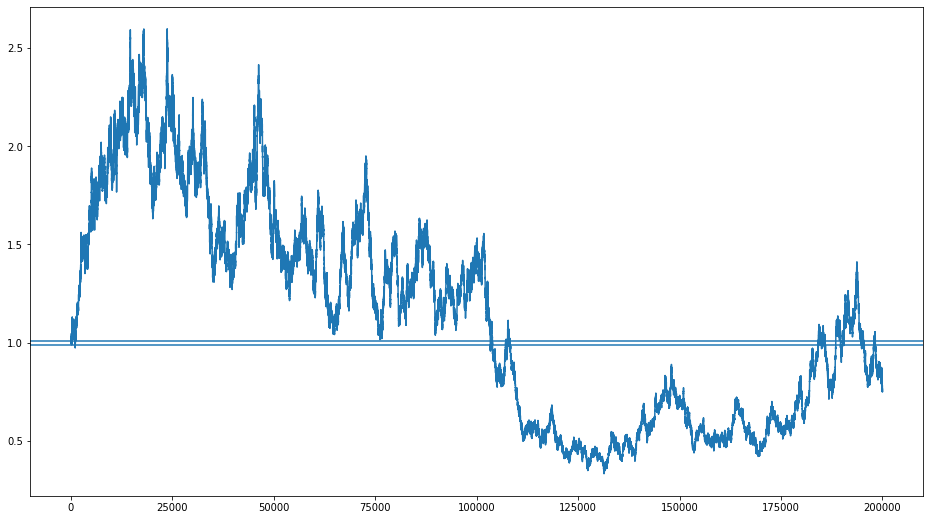

In [18]:
plt.figure(figsize = (16, 9))
a = 0.01
price_series = pd.read_csv("simulation_price.csv")['price']
price_high = price_series[0] * np.exp(a)
price_low = price_series[0] * np.exp(-a)
print(price_low, price_high)
plt.axhline(price_high)
plt.axhline(price_low)
plt.plot(price_series)

In [85]:
source_folders = "pool_detail"
results_df = pd.DataFrame()
for pool in sorted(os.listdir(source_folders)):
    try:
        row_dict = {}
        folder_path = source_folders + "/" + pool
        profit_dict = {}

        row_dict['pool'] = pool
        for csv in sorted(os.listdir(folder_path)):
            if "epoc" in csv and "optimum" not in csv:
                df = pd.read_csv(folder_path + "/" + csv)
                profit_dict[csv] = sum(df['end_wealth'] - df['holding_wealth']) / max(df['invest_wealth'])
        max_pnl = max(profit_dict.values())
        for (k, v) in profit_dict.items():
            if v == max_pnl:
                row_dict['best_b'] = k
                row_dict['best_b_apr'] = v
                row_dict['b'] = float(k[:-9].replace("_", "."))
                # row_dict['theo_IL'] = -(np.exp(row_dict['b']) - np.exp(-row_dict['b'])) / 4 * 200 / max(df['invest_wealth'])
                # row_dict['best_IL'] = sum((df['holding_wealth'] - df['end_wealth']) * (df['epoc_end_index'] - df['epoc_begin_index'])) / df.iloc[-1]['epoc_end_index']
                row_dict['best_fee_apr'] = sum(df['end_wealth_fee']) / max(df['invest_wealth'])
                row_dict['best_IL_apr'] = sum(df['end_wealth_in_pool'] - df['holding_wealth']) / max(df['invest_wealth'])
                break

        csv = "optimum_epoc.csv"
        df = pd.read_csv(folder_path + "/" + csv)
        row_dict['optimum_b'] = csv
        row_dict['optimum_b_apr'] = sum(df['end_wealth'] - df['holding_wealth']) / max(df['invest_wealth'])
        # row_dict['optimum_IL'] = sum((df['holding_wealth'] - df['end_wealth']) * (df['epoc_end_index'] - df['epoc_begin_index'])) / df.iloc[-1]['epoc_end_index']
        row_dict['optimum_fee_apr'] = sum(df['end_wealth_fee']) / max(df['invest_wealth'])
        row_dict['optimum_IL_apr'] = sum(df['end_wealth_in_pool'] - df['holding_wealth']) / max(df['invest_wealth'])
        results_df = results_df.append(row_dict, ignore_index=True)
    except Exception as e: pass

In [86]:
demo_df = results_df[['pool', 'best_b', 'best_b_apr', 'best_fee_apr', 'best_IL_apr', 'optimum_b_apr', 'optimum_fee_apr', 'optimum_IL_apr']]
demo_df.to_csv("pool_results.csv")